# Set up

In [22]:
import torch
import gpytorch
import pandas as pd
import numpy as np
import tqdm as tqdm

import ast
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import os
import pickle



import arviz as az
import seaborn as sns

import os
import scipy.stats as stats

from statsmodels.graphics.tsaplots import plot_acf
import statsmodels

from scipy.stats import gaussian_kde
from pyro.ops.stats import (
    gelman_rubin,
    split_gelman_rubin,
    autocorrelation,
    effective_sample_size,
    resample,
    quantile,
    weighed_quantile
)

import pickle

import torch.nn.functional as F


import GP_functions.Loss_function as Loss_function
import GP_functions.bound as bound
import GP_functions.Estimation as Estimation
import GP_functions.Training as Training
import GP_functions.Prediction as Prediction
import GP_functions.GP_models as GP_models
import GP_functions.Tools as Tools
import GP_functions.FeatureE as FeatureE

# Data

In [ ]:
# Y_RealCase_train = pd.read_csv('Data/Y_train_std.csv', header=None, delimiter=',')
# df_new = Y_RealCase_train.drop(Y_RealCase_train.columns[-18:], axis=1)
# Y_data_train = df_new.drop(df_new.columns[17], axis=1)

In [ ]:
# np.savetxt("Y_RealCase_train.csv", Y_data_train.values, delimiter=",", fmt="%.8f")

In [7]:
X_train = pd.read_csv('RealCase/RealCase_X_train.csv', header=None, delimiter=',').values
X_test = pd.read_csv('RealCase/RealCase_X_test.csv', header=None, delimiter=',').values

Y_train_pca = pd.read_csv('RealCase/RealCase_Y_train_pca.csv', header=None, delimiter=',').values
Y_test_pca = pd.read_csv('RealCase/RealCase_Y_test_pca.csv', header=None, delimiter=',').values
Realcase_data_pca = pd.read_csv('RealCase/RealCase_Y_pca.csv', header=None, delimiter=',').values

Y_train_std = pd.read_csv('RealCase/RealCase_Y_train_std.csv', header=None, delimiter=',').values
Y_test_std = pd.read_csv('RealCase/RealCase_Y_test_std.csv', header=None, delimiter=',').values
Realcase_data_std = pd.read_csv('RealCase/RealCase_Y_std.csv', header=None, delimiter=',').values

Y_train = pd.read_csv('RealCase/RealCase_Y_train.csv', header=None, delimiter=',').values
Y_test = pd.read_csv('RealCase/RealCase_Y_test.csv', header=None, delimiter=',').values
Realcase_data = pd.read_csv('RealCase/RealCase.csv', header=None, delimiter=',').values

In [8]:
train_x = torch.tensor(X_train, dtype=torch.float32)
test_x = torch.tensor(X_test, dtype=torch.float32)

train_y_pca = torch.tensor(Y_train_pca, dtype=torch.float32)
test_y_pca = torch.tensor(Y_test_pca, dtype=torch.float32)
realcase_y_pca = torch.tensor(Realcase_data_pca, dtype=torch.float32)

train_y = torch.tensor(Y_train_std, dtype=torch.float32)
test_y = torch.tensor(Y_test_std, dtype=torch.float32)
realcase_y = torch.tensor(Realcase_data_std, dtype=torch.float32)


In [ ]:
col_min = np.nanmin(Y_train, axis=0)
col_max = np.nanmax(Y_train, axis=0)


((Realcase_data >= col_min) & (Realcase_data <= col_max)).sum(axis=1)

In [ ]:
(Realcase_data >= col_min) & (Realcase_data <= col_max)

In [ ]:
col_min

In [ ]:
col_max

In [ ]:
Realcase_data

In [ ]:
Realcase_data_pca

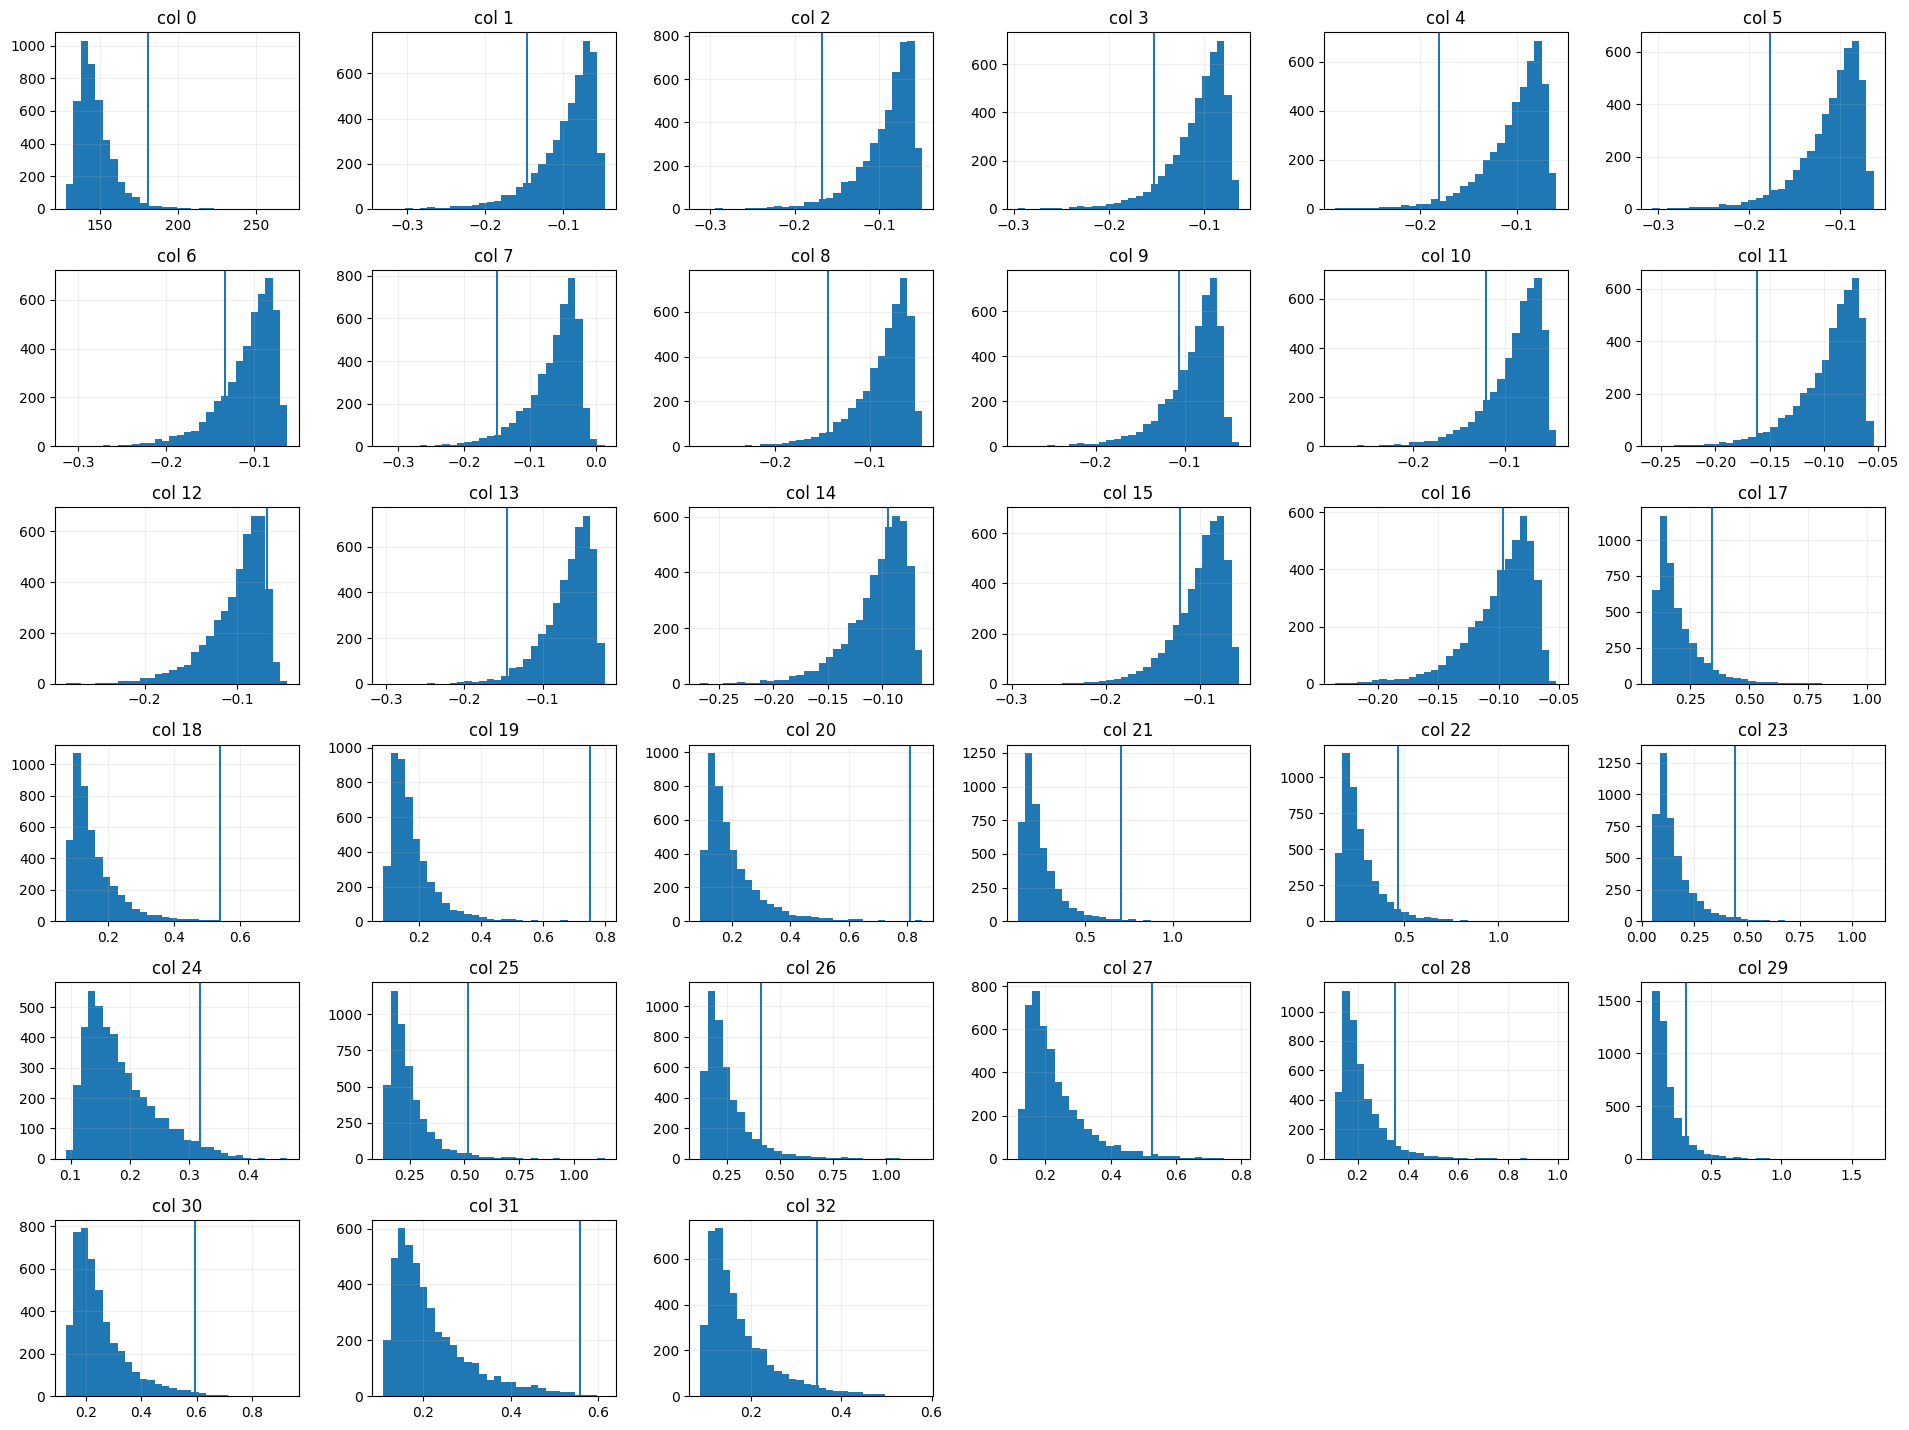

In [4]:
import math

def plot_hist_grid(Y, real, start=0, num=24, ncols=6, bins=30):
    real = np.asarray(real).squeeze()
    if real.ndim == 0:
        real = real[None]

    p = Y.shape[1]
    end = min(p, start + num)
    idxs = list(range(start, end))

    nrows = math.ceil(len(idxs) / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(3.2*ncols, 2.4*nrows), squeeze=False)

    for k, j in enumerate(idxs):
        r, c = divmod(k, ncols)
        ax = axes[r][c]
        ax.hist(Y[:, j], bins=bins)
        ax.axvline(real[j])  # RealCase 的位置
        ax.set_title(f"col {j}")
        ax.grid(alpha=0.2)

    # 多余子图关掉
    for k in range(len(idxs), nrows*ncols):
        r, c = divmod(k, ncols)
        axes[r][c].axis("off")

    plt.tight_layout()
    plt.show()

real = Realcase_data.squeeze()
plot_hist_grid(Y_train, real, start=0,  num=33)




# Emulator

In [7]:
train_y_17 = train_y[:,:17]
test_y_17 = test_y[:,:17]
realcase_y_17 = realcase_y[:,:17]

In [9]:
Device = 'cpu'

# Device = 'cuda'

In [9]:
MVGP_models, MVGP_likelihoods = Training.train_MultitaskVGP_minibatch(
    train_x=train_x.to(Device),
    train_y=train_y_17.to(Device),
    covar_type='RBF',
    num_latents=42,
    num_inducing=500,
    lr_hyper=0.01,
    lr_variational=0.1,
    num_iterations=10000,
    patience=10,
    device=Device,
    batch_size=512,
    eval_every=100,
    eval_batch_size=1024
)

Training: 100%|█████████▉| 9999/10000 [12:28<00:00, 13.37it/s, full_loss=-12.6]  


In [ ]:
Prediction.preds_for_one_model(MVGP_models, MVGP_likelihoods, train_x[0].cuda().unsqueeze(0))

In [ ]:
train_y_17[0]

## MVGP

In [10]:
checkpoint = torch.load('multitask_gp_checkpoint_Realcase.pth', map_location=Device)
model_params = checkpoint['model_params']

MVGP_models = GP_models.MultitaskVariationalGP(train_x, train_y, 
                                               num_latents=model_params['num_latents'],
                                               num_inducing=model_params['num_inducing'],  
                                               covar_type=model_params['covar_type']).to(Device)

MVGP_models.load_state_dict(checkpoint['model_state_dict'])

MVGP_likelihoods = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=train_y.shape[1]).to(Device)
MVGP_likelihoods.load_state_dict(checkpoint['likelihood_state_dict'])

MVGP_models.eval()
MVGP_likelihoods.eval()


MultitaskGaussianLikelihood(
  (raw_task_noises_constraint): GreaterThan(1.000E-04)
  (raw_noise_constraint): GreaterThan(1.000E-04)
)

# PE

In [10]:
row_idx = 0

input_point = realcase_y_17

local_train_x, local_train_y = Tools.find_k_nearest_neighbors_GPU(input_point, train_x, train_y_17, k=300)

bounds = bound.get_bounds(local_train_x)

In [11]:
bounds

[(np.float32(0.1224), np.float32(4.9783)),
 (np.float32(0.1191), np.float32(4.9865)),
 (np.float32(0.1664), np.float32(4.9737)),
 (np.float32(0.113), np.float32(4.9934)),
 (np.float32(0.1058), np.float32(4.5199)),
 (np.float32(0.1097), np.float32(4.9996)),
 (np.float32(0.1002), np.float32(3.3735)),
 (np.float32(0.1071), np.float32(4.9898)),
 (np.float32(0.1213), np.float32(4.9858)),
 (np.float32(0.1041), np.float32(4.9712))]

In [12]:
estimated_params_tmp, Loss_tmp = Estimation.multi_start_estimation(
        MVGP_models, MVGP_likelihoods, row_idx, realcase_y_17, bounds,
        Estimation.estimate_params_for_one_model_Adam, num_starts=16, num_iterations=2000, lr=0.01,
        patience=15, attraction_threshold=0.1, repulsion_strength=0.1, device=Device
    )

In [13]:
estimated_params_tmp

array([2.331779  , 0.1191    , 3.3170652 , 1.2486118 , 1.4911077 ,
       0.1097    , 1.3861945 , 0.11462227, 0.453993  , 4.9712    ],
      dtype=float32)

In [14]:
Loss_tmp

2.259986162185669

In [ ]:
test_r = [np.float32(0.10105), 
          np.float32(4.98), 
          np.float32(0.38), 
          np.float32(4.99), 
          np.float32(0.275), 
          np.float32(1.02), 
          np.float32(0.1007), 
          np.float32(4.98), 
          np.float32(0.1054), 
          np.float32(4.97)]

In [ ]:
torch.tensor(test_r)

In [ ]:
Prediction.preds_for_one_model(MVGP_models, MVGP_likelihoods, torch.tensor(test_r).cuda().unsqueeze(0))

In [ ]:
input_point

# Check result

In [ ]:
MVGP_pca_result = pd.read_csv('RealCase/Result/MVGP_21_result.csv')
MVGP_pca_result['estimated_params_list'] = MVGP_pca_result['estimated_params'].apply(ast.literal_eval)

MVGP_pca_result = np.array(MVGP_pca_result['estimated_params_list'].tolist())

In [ ]:
MVGP_pca_result

In [ ]:
realcase_paras_pca = torch.tensor(MVGP_pca_result, dtype=torch.float32)

In [ ]:
preds_tmp = Prediction.preds_for_one_model(
        MVGP_models, MVGP_likelihoods, realcase_paras_pca.to(Device)
        ).cpu().detach().numpy()

# MCMC

In [15]:
mcmc_result_Uniform = Estimation.run_mcmc_Uniform(
    Prediction.preds_distribution, MVGP_models, MVGP_likelihoods, 
    row_idx, realcase_y_17, bounds, 
    num_sampling=1200, warmup_step=300, num_chains=1, device=Device
)
posterior_samples_Uniform = mcmc_result_Uniform.get_samples()

Sample: 100%|██████████| 1500/1500 [39:45,  1.59s/it, step size=4.91e-02, acc. prob=0.934]


In [16]:
torch.save(posterior_samples_Uniform, "mcmc_RealCase_test.pt")

# MCMC Check

In [5]:
with open("RealCase/Result/MVGP_21_mcmc_result/result_1.pkl", "rb") as f:
    loaded_samples_chain1 = pickle.load(f)

In [3]:
loaded_samples = torch.load("mcmc_RealCase_test.pt", map_location=Device)

In [16]:
mean_est   = {k: v.mean(dim=0) for k, v in loaded_samples.items()}
median_est = {k: v.median(dim=0).values for k, v in loaded_samples.items()}

In [29]:
PE_est = torch.tensor([2.331779  , 0.1191    , 3.3170652 , 1.2486118 , 1.4911077 ,0.1097    , 1.3861945 , 0.11462227, 0.453993  , 4.9712])

In [30]:
F.mse_loss(Prediction.preds_for_one_model(MVGP_models, MVGP_likelihoods, PE_est.cpu().unsqueeze(0)), realcase_y)

/tmp/ipykernel_271627/3900732413.py:1: UserWarning: Using a target size (torch.Size([1, 33])) that is different to the input size (torch.Size([33])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  F.mse_loss(Prediction.preds_for_one_model(MVGP_models, MVGP_likelihoods, PE_est.cpu().unsqueeze(0)), realcase_y)


tensor(3.0575, grad_fn=<MseLossBackward0>)

In [27]:
mean_est_tensor = torch.stack([mean_est[f"param_{i}"] for i in range(len(mean_est))])
median_est_tensor = torch.stack([median_est[f"param_{i}"] for i in range(len(median_est))])

In [25]:
F.mse_loss(Prediction.preds_for_one_model(MVGP_models, MVGP_likelihoods, mean_est_tensor.cpu().unsqueeze(0)), realcase_y)

/tmp/ipykernel_271627/2847040494.py:1: UserWarning: Using a target size (torch.Size([1, 33])) that is different to the input size (torch.Size([33])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  F.mse_loss(Prediction.preds_for_one_model(MVGP_models, MVGP_likelihoods, mean_est_tensor.cpu().unsqueeze(0)), realcase_y)


tensor(3.1654, grad_fn=<MseLossBackward0>)

In [28]:
F.mse_loss(Prediction.preds_for_one_model(MVGP_models, MVGP_likelihoods, median_est_tensor.cpu().unsqueeze(0)), realcase_y)

/tmp/ipykernel_271627/486602977.py:1: UserWarning: Using a target size (torch.Size([1, 33])) that is different to the input size (torch.Size([33])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  F.mse_loss(Prediction.preds_for_one_model(MVGP_models, MVGP_likelihoods, median_est_tensor.cpu().unsqueeze(0)), realcase_y)


tensor(3.1252, grad_fn=<MseLossBackward0>)

In [4]:
def approx_mode_hist(x, bins=60):
    x = x.detach().flatten()
    xmin, xmax = x.min().item(), x.max().item()
    hist = torch.histc(x, bins=bins, min=xmin, max=xmax)
    idx = int(hist.argmax())
    edges = torch.linspace(xmin, xmax, bins + 1)
    return 0.5 * (edges[idx] + edges[idx + 1])

mode_est = {}
for k, v in loaded_samples.items():

    if v.ndim == 1:
        mode_est[k] = approx_mode_hist(v)
    else:
        mode_est[k] = torch.stack([approx_mode_hist(v[:, i]) for i in range(v.shape[1])])

print(mode_est)

{'param_0': tensor(2.2888), 'param_1': tensor(0.1250), 'param_2': tensor(3.9497), 'param_3': tensor(1.6686), 'param_4': tensor(0.1079), 'param_5': tensor(2.2909), 'param_6': tensor(1.3089), 'param_7': tensor(0.1650), 'param_8': tensor(0.6204), 'param_9': tensor(4.9653)}


In [11]:
test_r = [np.float32(2.2888), 
          np.float32(0.1250), 
          np.float32(3.9497), 
          np.float32(1.6686), 
          np.float32(0.1079), 
          np.float32(2.2909), 
          np.float32(1.3089), 
          np.float32(0.1650), 
          np.float32(0.6204), 
          np.float32(4.9653)]

In [13]:
Prediction.preds_for_one_model(MVGP_models, MVGP_likelihoods, torch.tensor(test_r).cpu().unsqueeze(0))

tensor([ 2.1112, -2.3061, -2.3315, -1.6843, -2.2133, -2.2342,  0.0975, -2.3161,
        -2.3428, -0.7527, -1.9530, -2.6022,  0.5067, -1.2585, -0.3613, -0.8258,
        -0.1415,  2.1724,  2.1508,  1.9092,  2.3851,  2.0129,  0.0519,  2.0720,
         1.6165,  1.1376,  2.0386,  2.5301, -0.0047,  0.3140, -0.0517,  0.3098,
         0.2520], grad_fn=<ViewBackward0>)

In [15]:
realcase_y

tensor([[ 2.9414, -1.3782, -2.3339, -1.5402, -2.4168, -1.9661, -0.7328, -2.0328,
         -1.8610, -0.4469, -0.9465, -2.3384,  1.0405, -2.4893,  0.3288, -0.7487,
          0.0511,  1.4259,  5.1436,  7.5060,  5.9425,  3.6054,  1.6821,  2.7982,
          2.3277,  2.7848,  1.4349,  3.1344,  1.5733,  1.1795,  3.4176,  3.8540,
          2.2828]])

In [ ]:
F.mse_loss(Prediction.preds_for_one_model(MVGP_models, MVGP_likelihoods, torch.tensor(test_r).cpu().unsqueeze(0)), realcase_y)

/tmp/ipykernel_271627/2233539217.py:3: UserWarning: Using a target size (torch.Size([1, 33])) that is different to the input size (torch.Size([33])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  F.mse_loss(Prediction.preds_for_one_model(MVGP_models, MVGP_likelihoods, torch.tensor(test_r).cpu().unsqueeze(0)), realcase_y)


tensor(3.0699, grad_fn=<MseLossBackward0>)

param_0: R-hat = 1.000, split R-hat = 0.999, ESS = 637.2


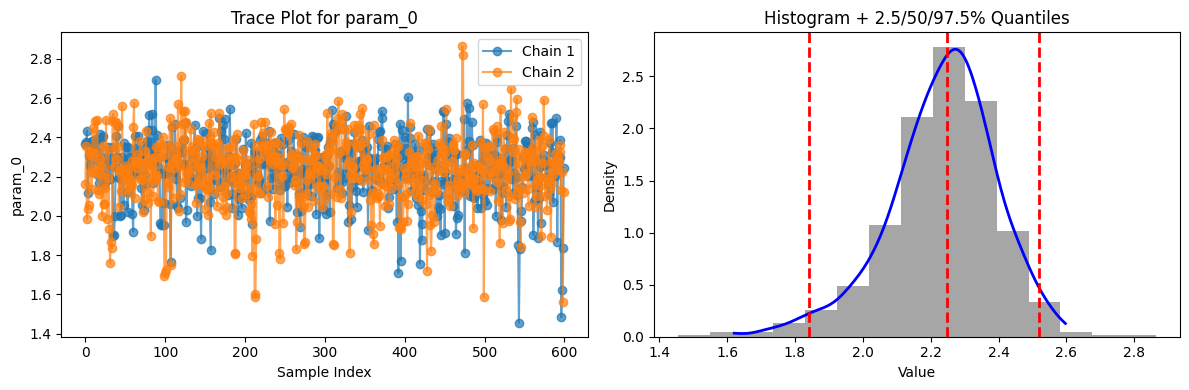

<Figure size 600x400 with 0 Axes>

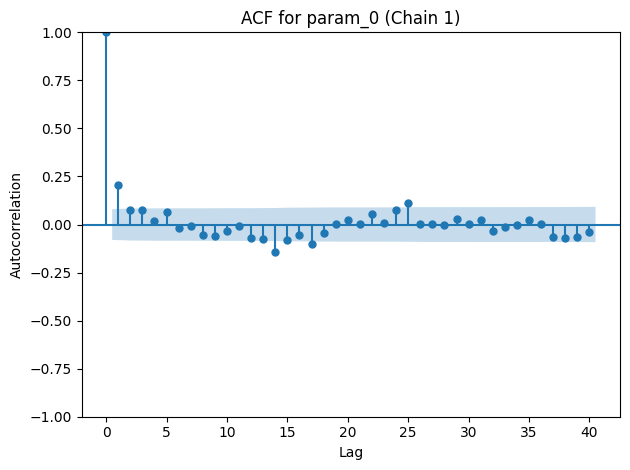

param_1: R-hat = 1.001, split R-hat = 1.001, ESS = 695.7


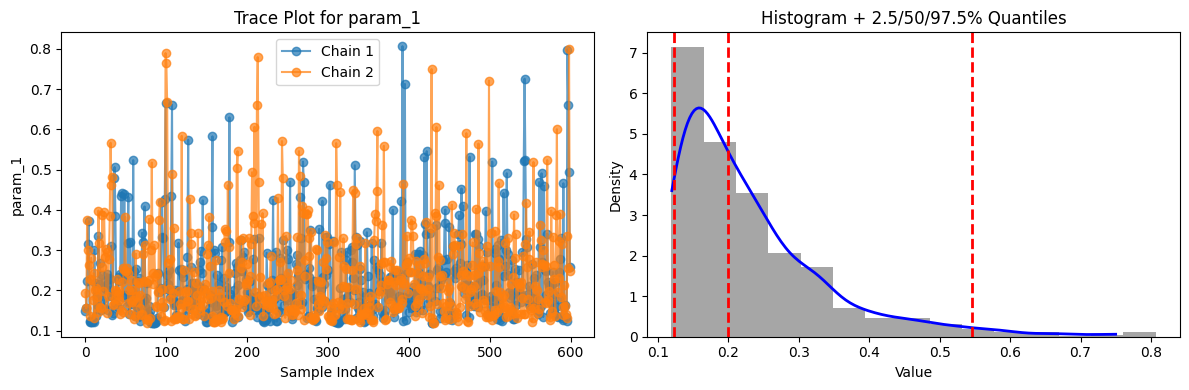

<Figure size 600x400 with 0 Axes>

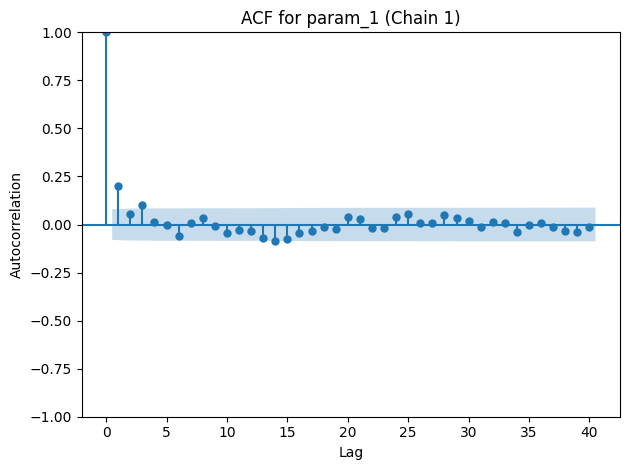

param_2: R-hat = 0.999, split R-hat = 0.999, ESS = 430.3


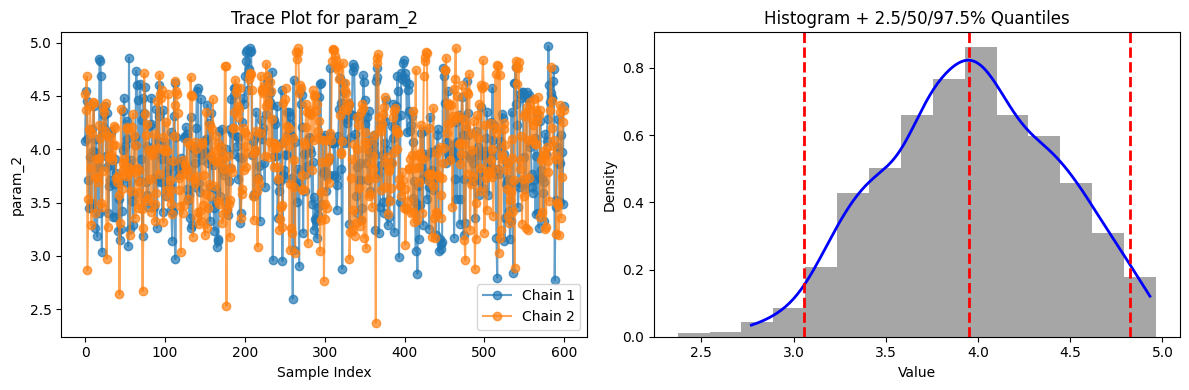

<Figure size 600x400 with 0 Axes>

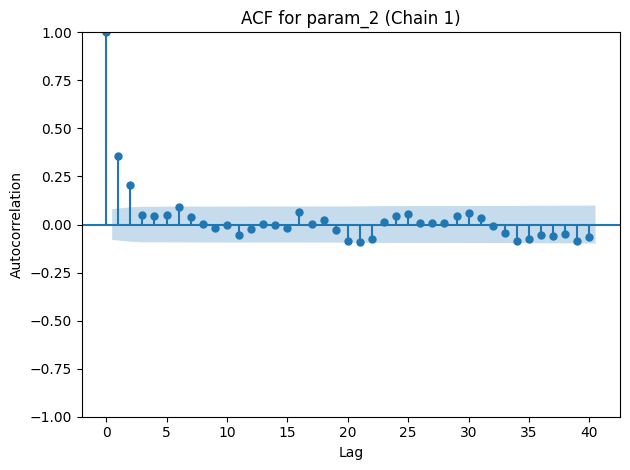

param_3: R-hat = 0.999, split R-hat = 0.999, ESS = 494.7


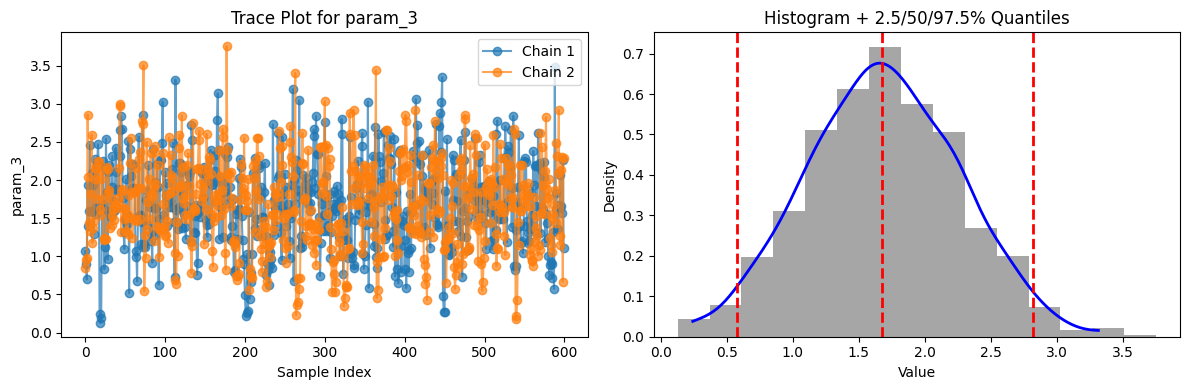

<Figure size 600x400 with 0 Axes>

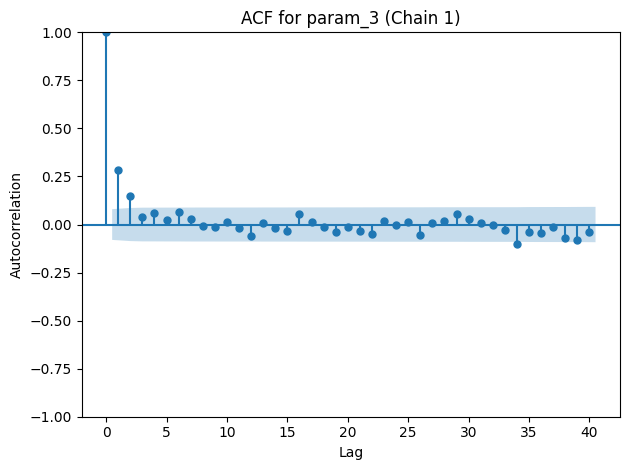

param_4: R-hat = 1.000, split R-hat = 1.001, ESS = 892.4


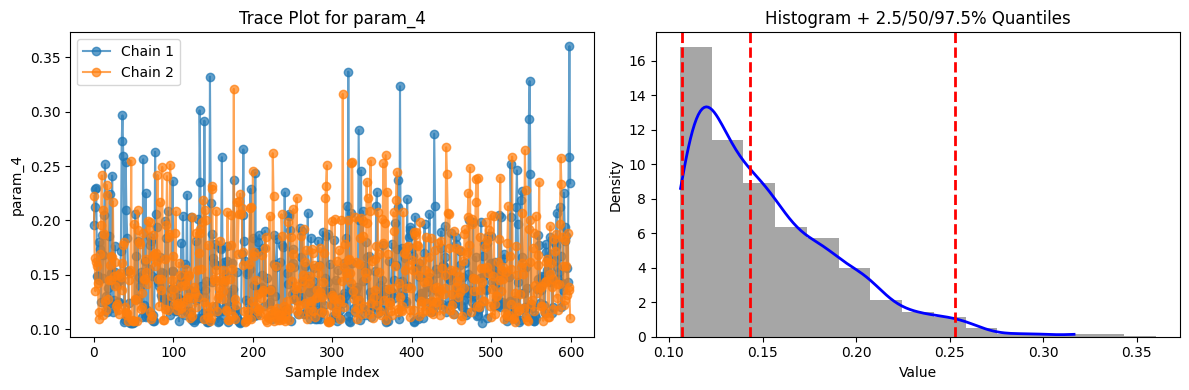

<Figure size 600x400 with 0 Axes>

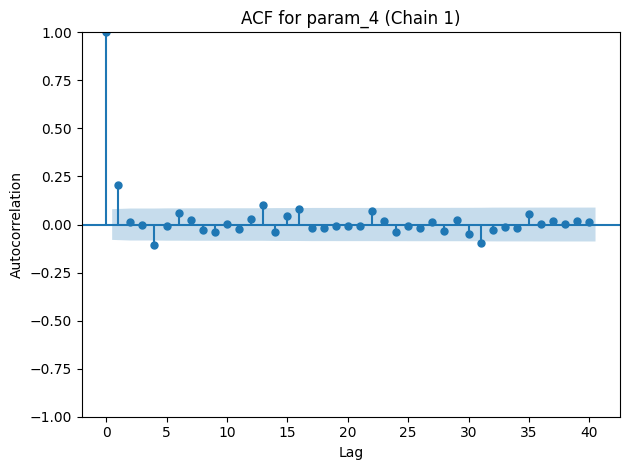

param_5: R-hat = 1.002, split R-hat = 1.004, ESS = 856.3


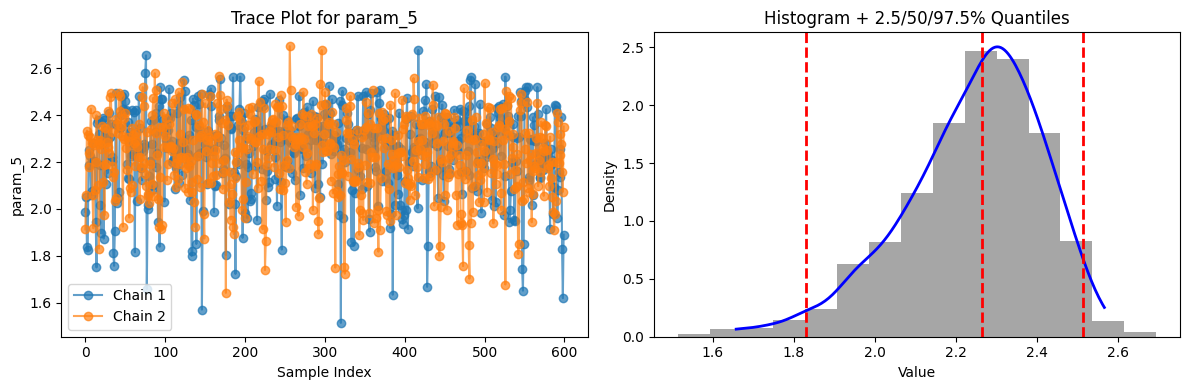

<Figure size 600x400 with 0 Axes>

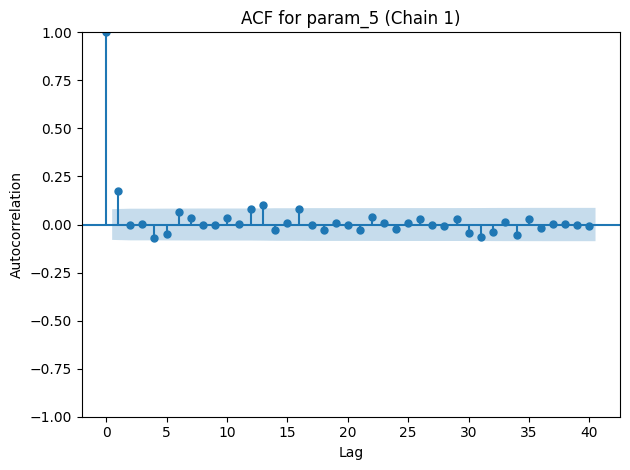

param_6: R-hat = 1.000, split R-hat = 1.001, ESS = 456.2


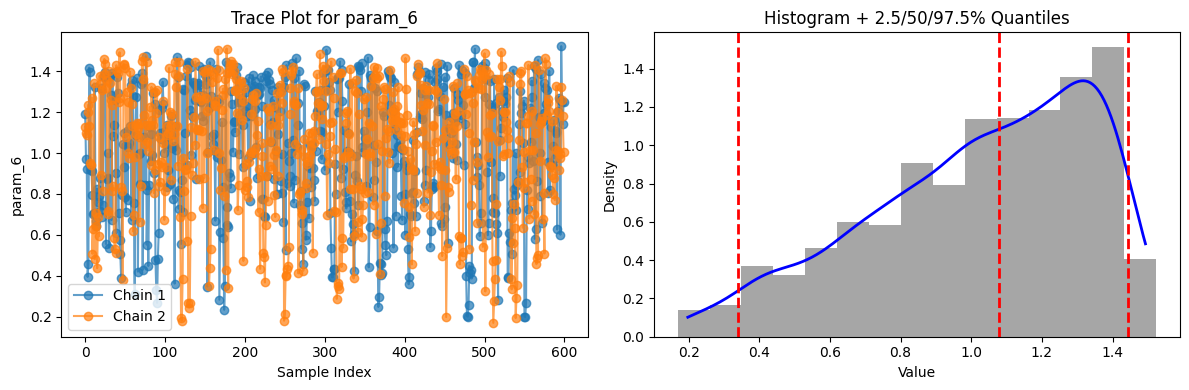

<Figure size 600x400 with 0 Axes>

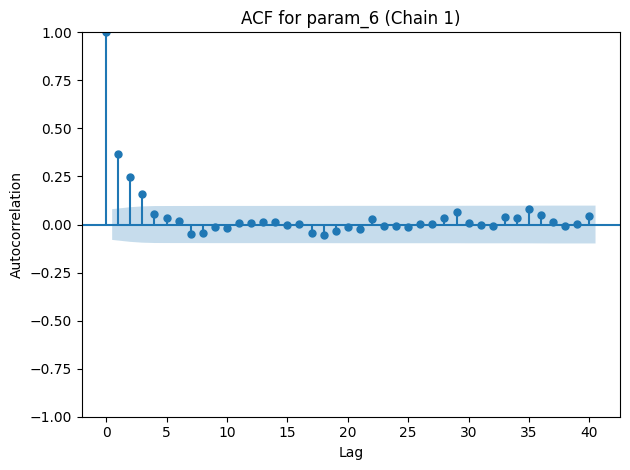

param_7: R-hat = 1.000, split R-hat = 1.001, ESS = 423.5


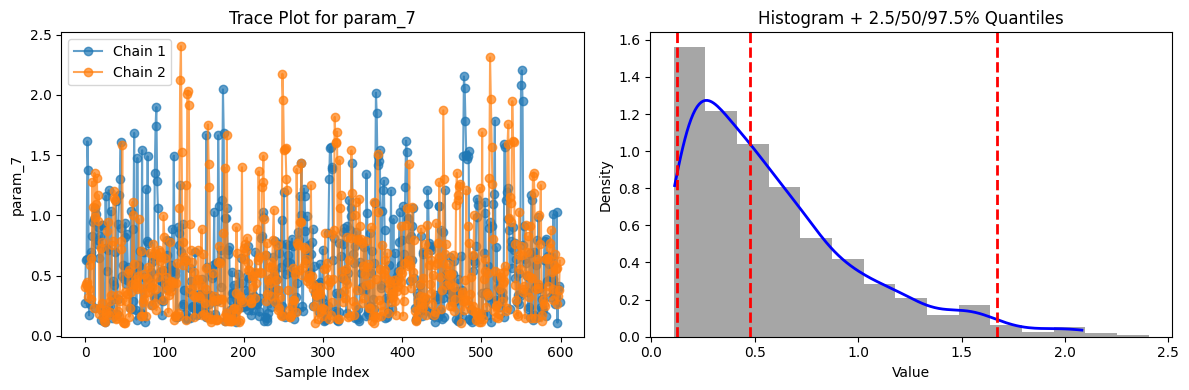

<Figure size 600x400 with 0 Axes>

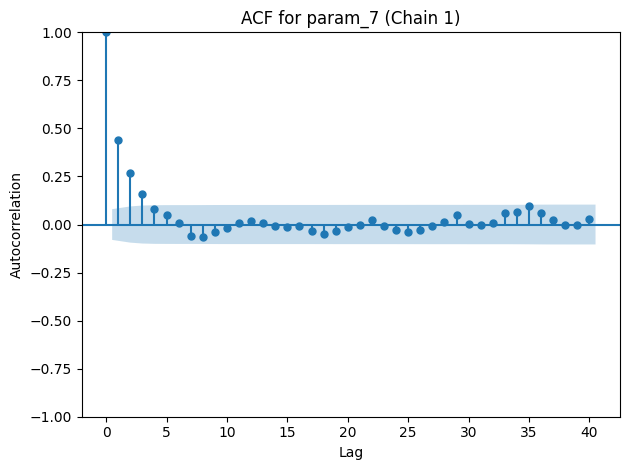

param_8: R-hat = 0.999, split R-hat = 1.000, ESS = 655.0


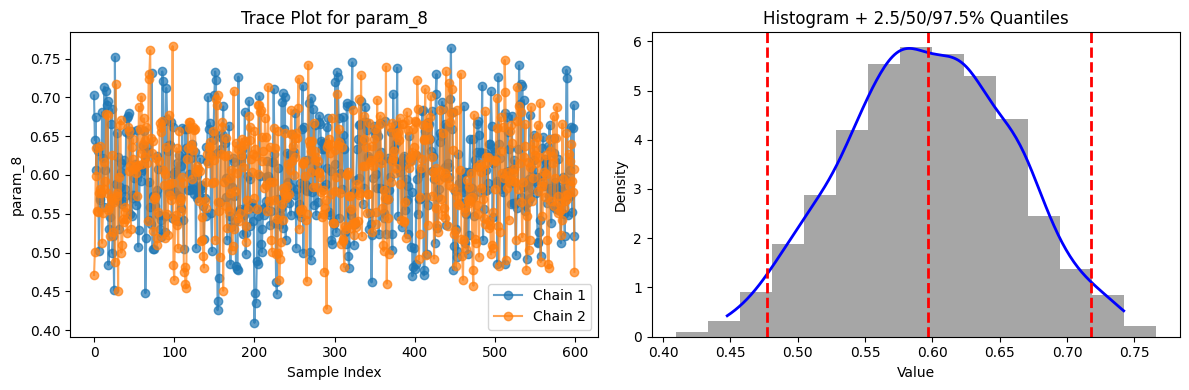

<Figure size 600x400 with 0 Axes>

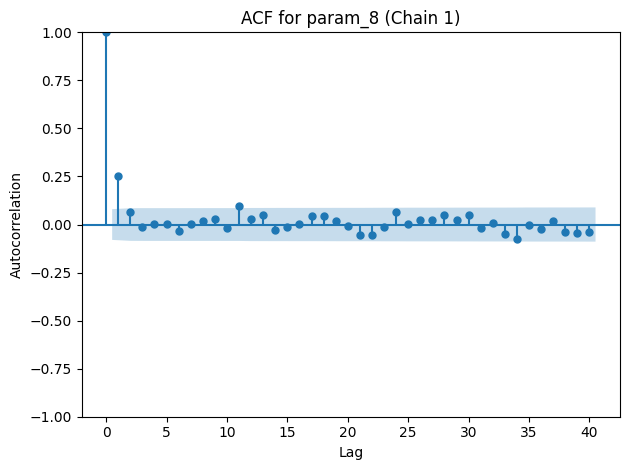

param_9: R-hat = 1.000, split R-hat = 1.000, ESS = 756.2


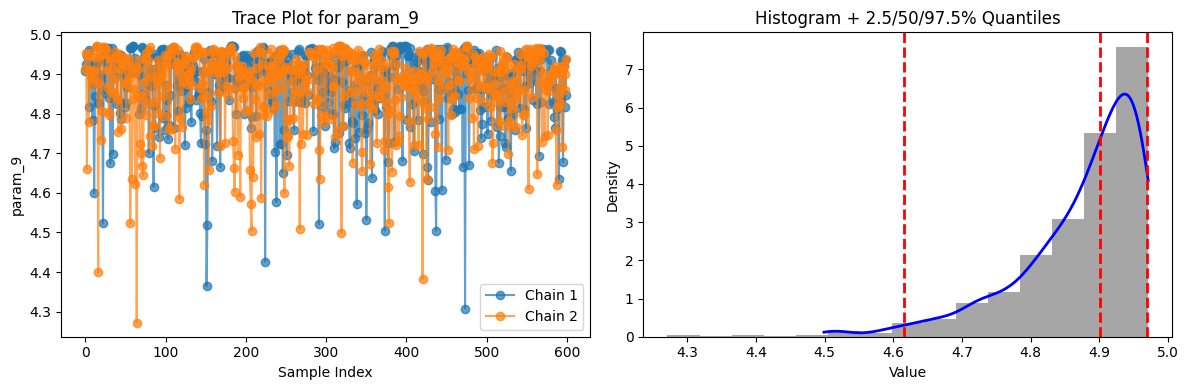

<Figure size 600x400 with 0 Axes>

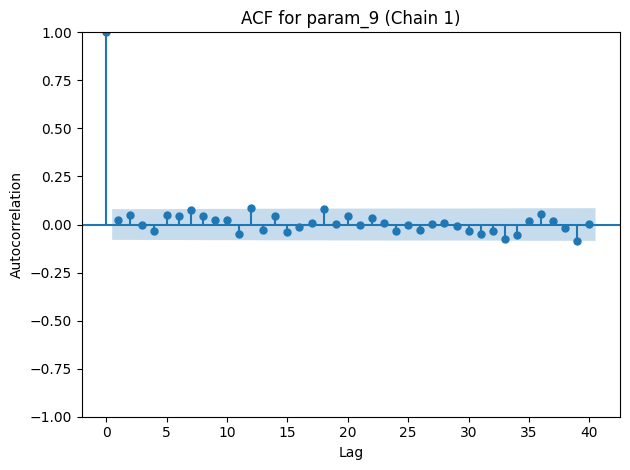

In [17]:
single_chain_samples = posterior_samples_Uniform  # dict: param -> Tensor[n_samples]

# 将每条参数的样本拆成两半
def split_chain(chain_tensor):
    n = chain_tensor.shape[0]
    half = n // 2
    return chain_tensor[:half], chain_tensor[half:2*half]

# 整理成 mcmc_samples：param -> Tensor[2, n_half]
mcmc_samples = {}
for param, samples in single_chain_samples.items():
    chain_a, chain_b = split_chain(samples)
    # 如果原链长度是奇数，可以选择丢弃最后一个样本或做其他处理
    mcmc_samples[param] = torch.stack([chain_a, chain_b], dim=0)




# 诊断和可视化
for param, samples_chains in mcmc_samples.items():

    
    # 计算诊断量
    rhat = gelman_rubin(samples_chains, chain_dim=0, sample_dim=1)
    split_rhat = split_gelman_rubin(samples_chains, chain_dim=0, sample_dim=1)
    ess = effective_sample_size(samples_chains, chain_dim=0, sample_dim=1)
    print(f"{param}: R-hat = {rhat:.3f}, split R-hat = {split_rhat:.3f}, ESS = {ess:.1f}")
    
    # 绘制 Trace Plot
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    for i in range(2):
        plt.plot(samples_chains[i].cpu().numpy(), marker='o', label=f"Chain {i+1}", alpha=0.7)

    plt.title(f"Trace Plot for {param}")
    plt.xlabel("Sample Index")
    plt.ylabel(param)
    plt.legend()
    
    # 绘制 Histogram + Quantiles
    plt.subplot(1, 2, 2)
    all_samps = samples_chains.reshape(-1).cpu().numpy()

    xmin, xmax = np.percentile(all_samps, [0.5, 99.5])

    plt.hist(all_samps, bins=15, density=True, alpha=0.7, color='gray')

    kde = gaussian_kde(all_samps)
    x_grid = np.linspace(xmin, xmax, 200)
    # plt.plot(x_grid, kde(x_grid), color='blue', linewidth=2, label="KDE")
    plt.plot(x_grid, kde(x_grid), color='blue', linewidth=2)

    qs = torch.quantile(torch.from_numpy(all_samps), torch.tensor([0.025, 0.5, 0.975]))
    for q in qs:
        plt.axvline(q.item(), color='red', linestyle='--', linewidth=2)
    
    # plt.xlim(0.1, 5)

    plt.title(f"Histogram + 2.5/50/97.5% Quantiles")
    plt.xlabel("Value")
    plt.ylabel("Density")
    plt.tight_layout()
    plt.show()
    
    # 绘制 ACF（仅第一“伪链”）
    plt.figure(figsize=(6,4))
    plot_acf(samples_chains[0].cpu().numpy(), lags=40)
    plt.title(f"ACF for {param} (Chain 1)")
    plt.xlabel("Lag")
    plt.ylabel("Autocorrelation")
    plt.tight_layout()
    plt.show()

# End